In [1]:
import numpy as np
import pickle, torch, random
from matplotlib import pyplot as plt
from vit.models import SingleDecoder
from torch import nn
from einops import repeat, rearrange

In [2]:
length = 50
n_batch = 64
dim = 128
n_output = 2
input_dim = 4 * 7
adapter_dim = 16

In [3]:
class MultiCrossEntropyLoss(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, output, target):
        sm = torch.softmax(output, dim=-1)
        return -(target * torch.log(sm)).sum()

In [4]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [5]:
model = SingleDecoder(input_dim=input_dim, length=length, dim=dim, output_dim=n_output+1, mlp_head=True, patch_size=(5, 1), adapter_dim=adapter_dim).cuda()
criterion = MultiCrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [6]:
ls = 0
loss_save = []
for i in range(3000):
    optimizer.zero_grad()
    # Inputの0,2番が同期活動（Baseline+2）しているタイミングがあるならTargetの0番が1
    # Inputの1,3番が同期活動（Baseline+2）しているタイミングがあるならTargetの1番が1
    # 両方同期していないならTargetの2が1
    inputs = torch.rand((n_batch, 1, length, input_dim)).cuda()
    # Targetの0番と1番の結果を決める
    t = np.random.randint(2, size=(n_batch, 2)) == 1
    # 活動（Baseline+2）させる位置を決める
    r = np.array([[np.random.permutation(length//5) * 5 for _ in range(n_batch)] for _ in range(2)])
    for j in range(2):
        for k in range(n_batch):
            # Inputのj(= 0 or 1)番を2か所活動させる
            inputs[k, 0, r[j, k, :2], 7*j:7*(j+1)] += 5
            # Targetのj(= 0 or 1)番が1のとき、Inputのj+2(= 2 or 3)番を1か所、Inputのj番と同じところを活動させる
            if t[k, j]:
                inputs[k, 0, r[j, k, 0], 7*(j+2):7*(j+3)] += 5
            # Targetのj(= 0 or 1)番が0のときは、Inputのj+2(= 2 or 3)番の、Inputのj番とは異なるところを1か所活動させる
            else:
                inputs[k, 0, r[j, k, 2], 7*(j+2):7*(j+3)] += 5
            # Inputのj+2(= 2 or 3)番を追加でもう1か所活動させる
            inputs[k, 0, r[j, k, -1], 7*(j+2):7*(j+3)] += 5

    # Targetを数値で表現する（dim=1方向の和が1になる）
    target = np.zeros((n_batch, n_output+1)).astype(np.float32)
    target[t[:, 0], 0] = 1
    target[t[:, 1], 1] = 1
    target[target.sum(axis=1) == 0, 2] = 1
    target /= target.sum(axis=1).reshape(-1, 1)
    target = torch.tensor(target).cuda()
    
    output = model(inputs)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    ls += loss.item()
    if (i + 1) % 100 == 0:
        print("iter: ", i+1, ", loss: ", ls)
        loss_save.append(ls)
        ls = 0

iter:  100 , loss:  6950.419483184814
iter:  200 , loss:  6923.604206085205
iter:  300 , loss:  4672.245323181152
iter:  400 , loss:  1847.0432891845703
iter:  500 , loss:  1383.8359022140503
iter:  600 , loss:  1184.67498254776
iter:  700 , loss:  1148.4021496772766
iter:  800 , loss:  1167.7834630012512
iter:  900 , loss:  1139.7953944206238
iter:  1000 , loss:  1151.3054633140564
iter:  1100 , loss:  1118.9552645683289
iter:  1200 , loss:  1129.779263973236
iter:  1300 , loss:  1135.9394626617432
iter:  1400 , loss:  1124.2874960899353
iter:  1500 , loss:  1138.1628518104553
iter:  1600 , loss:  1057.7474083900452
iter:  1700 , loss:  1109.0657858848572
iter:  1800 , loss:  1101.0590190887451
iter:  1900 , loss:  1132.1126294136047
iter:  2000 , loss:  1117.4670972824097
iter:  2100 , loss:  1315.4005489349365
iter:  2200 , loss:  1147.6202044487
iter:  2300 , loss:  1105.8219351768494
iter:  2400 , loss:  1108.1895213127136
iter:  2500 , loss:  1133.4865775108337
iter:  2600 , loss

([<matplotlib.axis.XTick at 0x2c47ac645f0>,
 [Text(0, 0, '0'),
  Text(5, 0, '500'),
  Text(10, 0, '1000'),
  Text(15, 0, '1500'),
  Text(20, 0, '2000'),
  Text(25, 0, '2500'),
  Text(30, 0, '3000')])

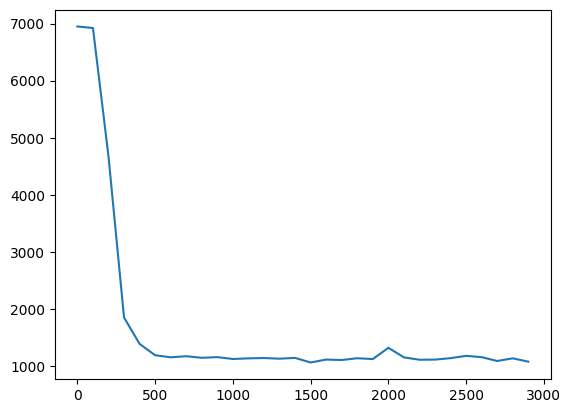

In [71]:
plt.plot(loss_save)
plt.xticks(np.arange(7) * 5, np.arange(7) * 500)

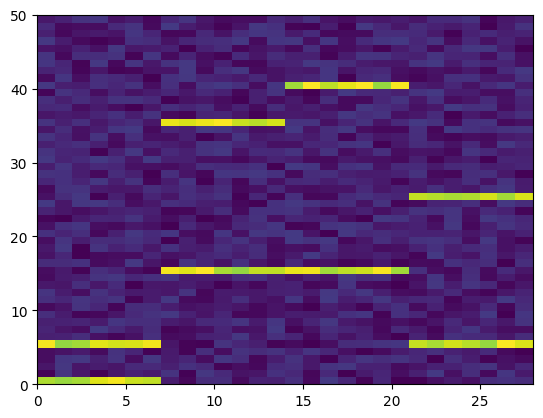

In [7]:
plt.pcolor(inputs[1, 0, :, :].detach().cpu().numpy())

Text(0.5, 0, 'Target ID')

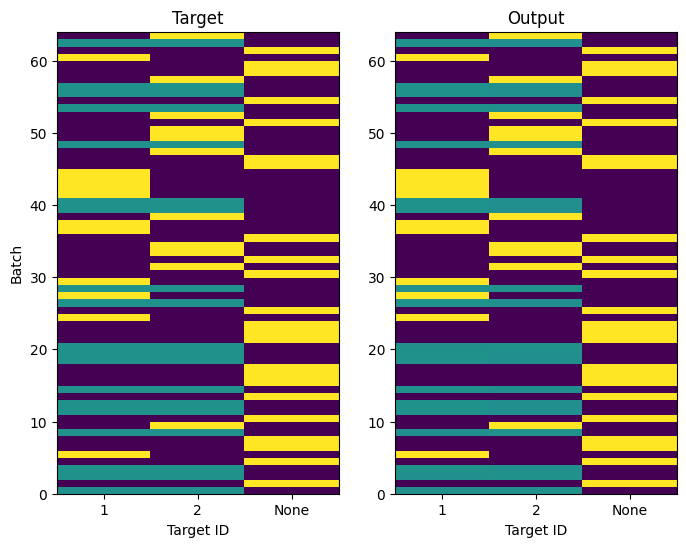

In [8]:
# TargetとOutputの比較
fig, ax = plt.subplots(1, 2, figsize=(8, 6))
ax[0].pcolor(target.detach().cpu().numpy())
ax[0].set_title("Target")
ax[0].set_ylabel("Batch")
ax[0].set_xlabel("Target ID")
ax[0].set_xticks([0.5, 1.5, 2.5])
ax[0].set_xticklabels(["1", "2", "None"])
ax[1].pcolor(torch.softmax(output, dim=1).detach().cpu().numpy())
ax[1].set_title("Output")
ax[1].set_xticks([0.5, 1.5, 2.5])
ax[1].set_xticklabels(["1", "2", "None"])
ax[1].set_xlabel("Target ID")

In [9]:
from fast_pytorch_kmeans import KMeans
from tqdm import tqdm
import math

class TIS:
    def __init__(self, model, batch_size=16, tokens_ratio=0.5, normalise=True, verbose=True, ablation_study=False):
        self.model = model

        self.batch_size = batch_size
        self.normalise = normalise
        self.verbose = verbose
        self.ablation_study = ablation_study

        if isinstance(tokens_ratio, float):
            tokens_ratio = [tokens_ratio]
        self.tokens_ratio = tokens_ratio

        self.encoder_activations = []
        self.encoder_hook_list = []
        self.cur_mask_indices = None
        
    def __call__(self, x, class_idx=None):
        x = self._align_dim(x)

        with torch.no_grad():
            predicted_class, encoder_activations = self.get_encoder_activations(x)
            if class_idx is None:
                class_idx = predicted_class
                if self.verbose:
                    print("class idx", class_idx)
            raw_masks = self.generate_raw_masks(encoder_activations)
            mask_list, mask_indices_list = self.generate_binary_masks(raw_masks)
            scores = self.generate_scores(x, class_idx, mask_indices_list)
            saliency_map = self.generate_saliency(scores, mask_list)
        return saliency_map
            
    def _align_dim(self, x):
        dim = x.dim()
        if dim == 3:
            return x.unsqueeze(0)
        elif dim == 4 and x.shape[0] == 1:
            return x
        else:
            raise ValueError("Only one image can be processed at a time")
            
    def get_encoder_activations(self, x):
        self.encoder_activations = []
        self.encoder_hook_list = []
        
        def encoder_hook_fn(_, __, output):
            self.encoder_activations.append(output.detach())

        for layer in self.model.tr.layers:
            self.encoder_hook_list.append(layer.register_forward_hook(encoder_hook_fn))

        predicted_class = torch.argmax(self.model(x))
        self.encoder_activations = torch.cat(self.encoder_activations, dim=-1)
        for hook in self.encoder_hook_list:
            hook.remove()
        self.encoder_hook_list = []
        return predicted_class, self.encoder_activations

    def generate_raw_masks(self, encoder_activations):
        encoder_activations = encoder_activations.squeeze(0)
        encoder_activations = encoder_activations[1:].T
        encoder_activations[:, :] = torch.rand(size=encoder_activations.shape)[:, :]
        return encoder_activations

    def generate_binary_masks(self, raw_masks):
        mask_indices_list = []
        mask_list = []
        
        for ratio in self.tokens_ratio:
            for raw_mask in raw_masks:
                n_tokens = int(ratio * raw_mask.flatten().shape[0])
                mask_indices = raw_mask.topk(n_tokens)[1]
                bin_mask = torch.zeros_like(raw_mask)
                bin_mask[mask_indices] = 1
                mask_indices_list.append(mask_indices)
                mask_list.append(bin_mask)
        return mask_list, mask_indices_list

    def generate_scores(self, x, class_idx, mask_indices_list):
        scores = []
        self.cur_mask_indices = None
        self.sampled_tokens = []

        def tokens_sampling_hook_fn(_, __, output):
            if self.cur_mask_indices is not None:
                cls = output[:, 0].unsqueeze(1)
                tokens = output[:, 1:]
                sampled_tokens = []
                for indices in self.cur_mask_indices:
                    cur_tokens = tokens[:, indices]
                    cur_tokens = torch.cat([cls, cur_tokens], dim=1)
                    sampled_tokens.append(cur_tokens)
                sampled_tokens = torch.cat(sampled_tokens)
                self.sampled_tokens.append(sampled_tokens)
                return sampled_tokens

        if not self.ablation_study:
            tokens_sampling_hook = self.model.pos_embed.register_forward_hook(tokens_sampling_hook_fn)

        self.results = []
        for idx in tqdm(range(math.ceil(len(mask_indices_list) / self.batch_size)), disable=(not self.verbose)):
            selection_slice = slice(idx * self.batch_size, min((idx + 1) * self.batch_size, len(mask_indices_list)))
            self.cur_mask_indices = mask_indices_list[selection_slice]
            if self.ablation_study:
                pass
                #result = self.model(self.mask_input(x)).detach()
            else:
                result = self.model(x).detach()
            result = torch.softmax(result, dim=1)
            #result = torch.sigmoid(result)
            self.results.append(result)
            score = result[:, class_idx]
            scores.append(score)

        if not self.ablation_study:
            tokens_sampling_hook.remove()
        self.cur_mask_indices = None

        scores = torch.cat(scores)
        return scores

    def generate_saliency(self, scores, mask_list):
        masks = torch.vstack(mask_list).T
        scored_masks = scores * masks
        raw_saliency = scored_masks.sum(-1)
        coverage_bias = masks.sum(-1)

        img_size = self.model.img_size
        patch_size = self.model.patch_size
        h = img_size[0] // patch_size[0]
        w = img_size[1] // patch_size[1]

        saliency = raw_saliency / coverage_bias
        saliency = saliency.reshape(h, w)
        
        if self.normalise:
            saliency = saliency - saliency.min()
            saliency = saliency / saliency.max()

        return saliency

In [10]:
model.eval()
out = model(inputs)

In [11]:
tis = TIS(model)

In [64]:
saliency = torch.stack([tis(inp, 1) for inp in inputs])

100%|█████████████████████████████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 221.11it/s]


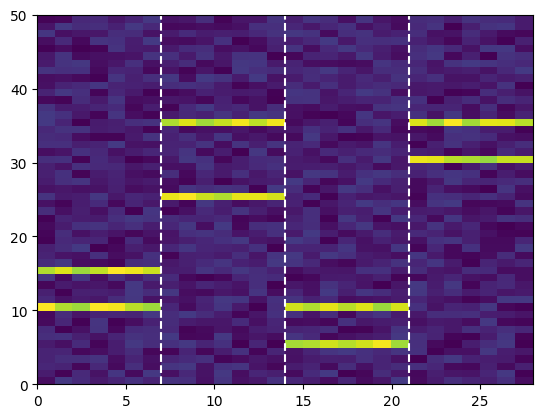

In [59]:
j = 0
plt.pcolor(inputs[j, 0].detach().cpu().numpy())
plt.vlines(x=[7, 14, 21], ymin=0, ymax=length, linestyle="--", color="w")

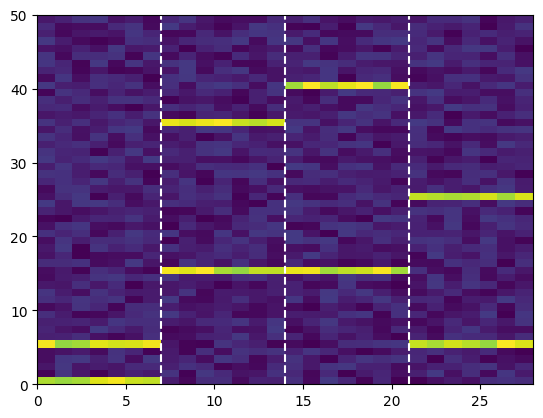

In [72]:
plt.pcolor(inputs[1, 0].detach().cpu().numpy())
plt.vlines(x=[7, 14, 21], ymin=0, ymax=length, linestyle="--", color="w")

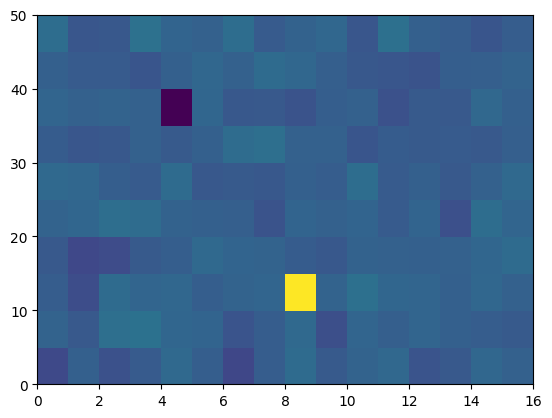

In [60]:
saliency_full = repeat(saliency, "b h w -> b c (h ph) (w pw)", c=1, ph=model.patch_size[0], pw=model.patch_size[1])
plt.pcolor(saliency_full[j, 0, :, :].detach().cpu().numpy())

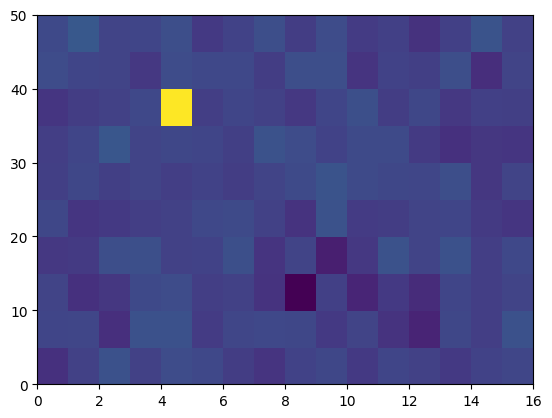

In [65]:
saliency_full = repeat(saliency, "b h w -> b c (h ph) (w pw)", c=1, ph=model.patch_size[0], pw=model.patch_size[1])
plt.pcolor(saliency_full[j, 0, :, :].detach().cpu().numpy())

In [66]:
sfm = saliency_full.mean(axis=[-2, -1]).unsqueeze(-1).unsqueeze(-1)
sfs = saliency_full.std(axis=[-2, -1]).unsqueeze(-1).unsqueeze(-1)
saliency_scale = (saliency_full - sfm) / sfs

In [67]:
matmul_raw = torch.stack([w * inputs for w in model.adapter.linear.weight])
adapter_output = model.adapter(inputs)
adapter_outputs = torch.stack([adapter_output for _ in range(matmul_raw.shape[-1])]).permute(4, 1, 2, 3, 0)

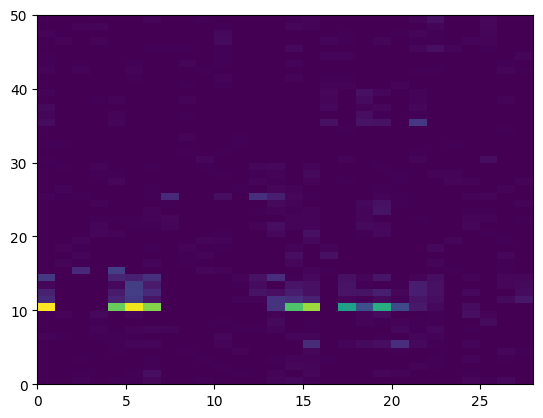

In [63]:
tmp = torch.vstack([torch.matmul(saliency_scale[j, 0, ti, :], (torch.sign(adapter_outputs) * matmul_raw)[:, j, 0, ti, :]) for ti in range(length)])
tmp[tmp < 0] = 0
plt.pcolor(tmp.detach().cpu().numpy())

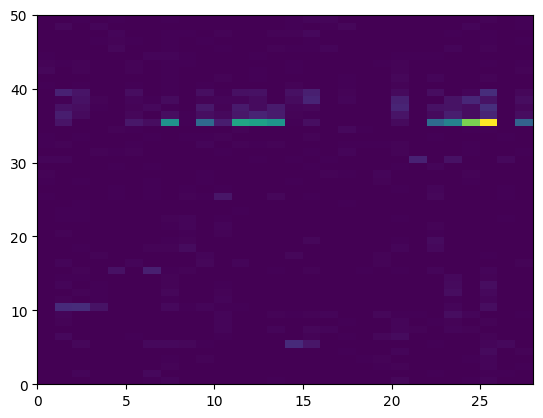

In [68]:
tmp = torch.vstack([torch.matmul(saliency_scale[j, 0, ti, :], (torch.sign(adapter_outputs) * matmul_raw)[:, j, 0, ti, :]) for ti in range(length)])
tmp[tmp < 0] = 0
plt.pcolor(tmp.detach().cpu().numpy())